In [20]:
!nvidia-smi

Sat Nov 26 14:53:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:65:00.0  On |                  N/A |
|  0%   32C    P8    13W / 370W |   9063MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7034736180393416807
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7781482496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12642736997741762472
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:65:00.0, compute capability: 8.6"
]


In [22]:
tf.test.is_gpu_available()

True

In [24]:
import os
import itertools
import numpy as np
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [6]:
folder_path = './car_semi_total'

In [7]:
pic_size = 300
epochs = 20
batch_size = 16
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
def plot_type(cartype):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = tf.keras.preprocessing.image.load_img(folder_path+ '/' + cartype + '/' +
                  os.listdir(folder_path +'/'+ cartype)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()

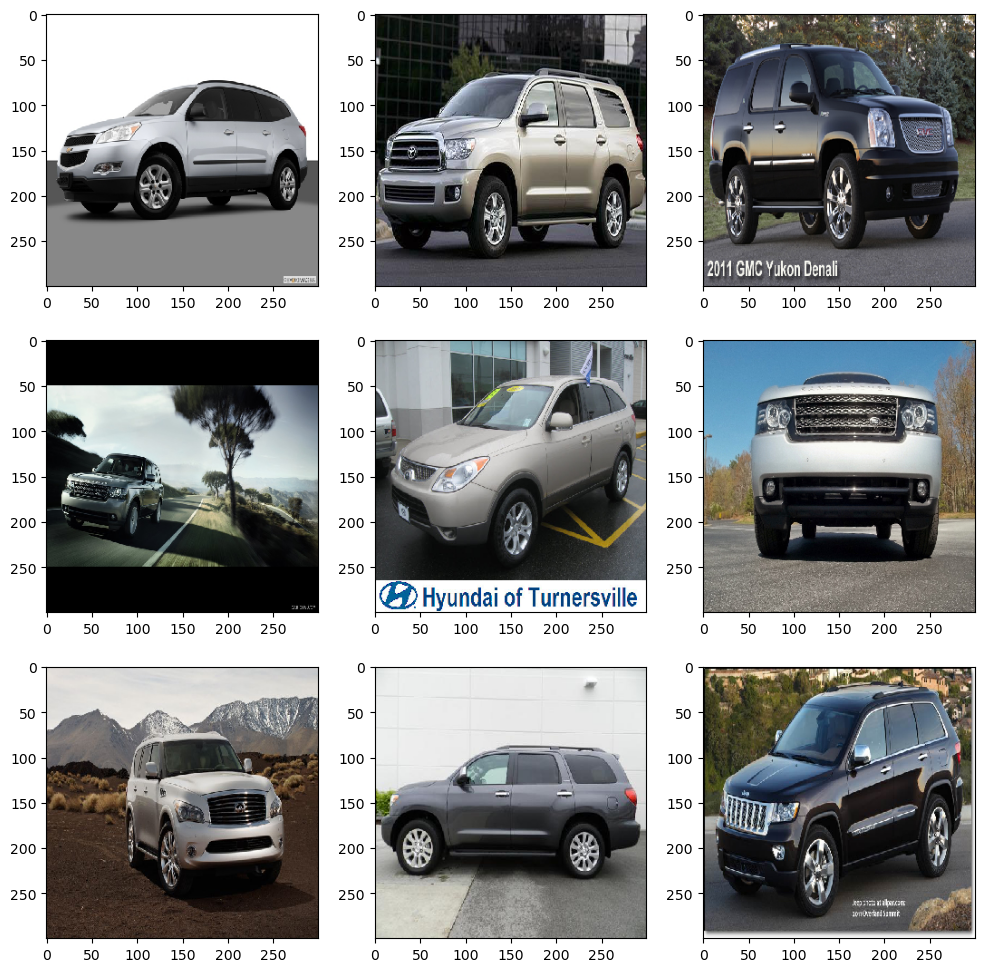

In [9]:
plot_type('suv')

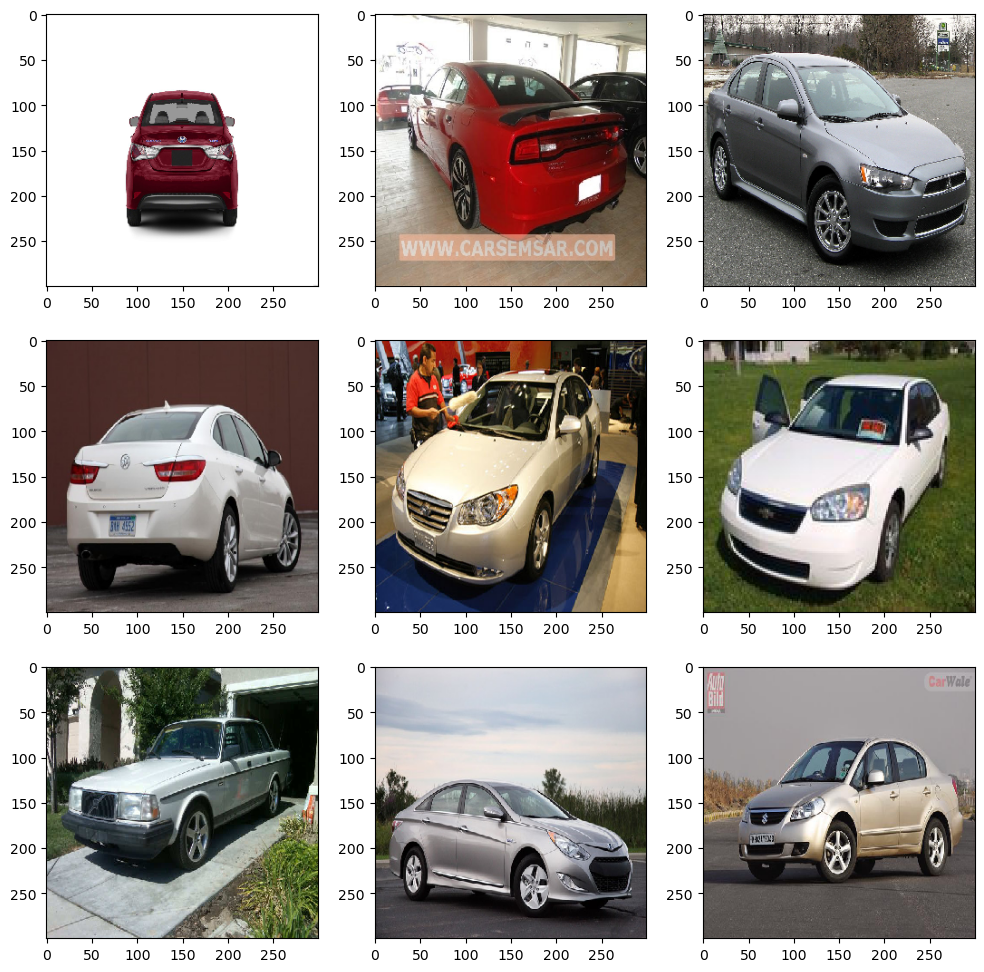

In [10]:
plot_type('Sedan')

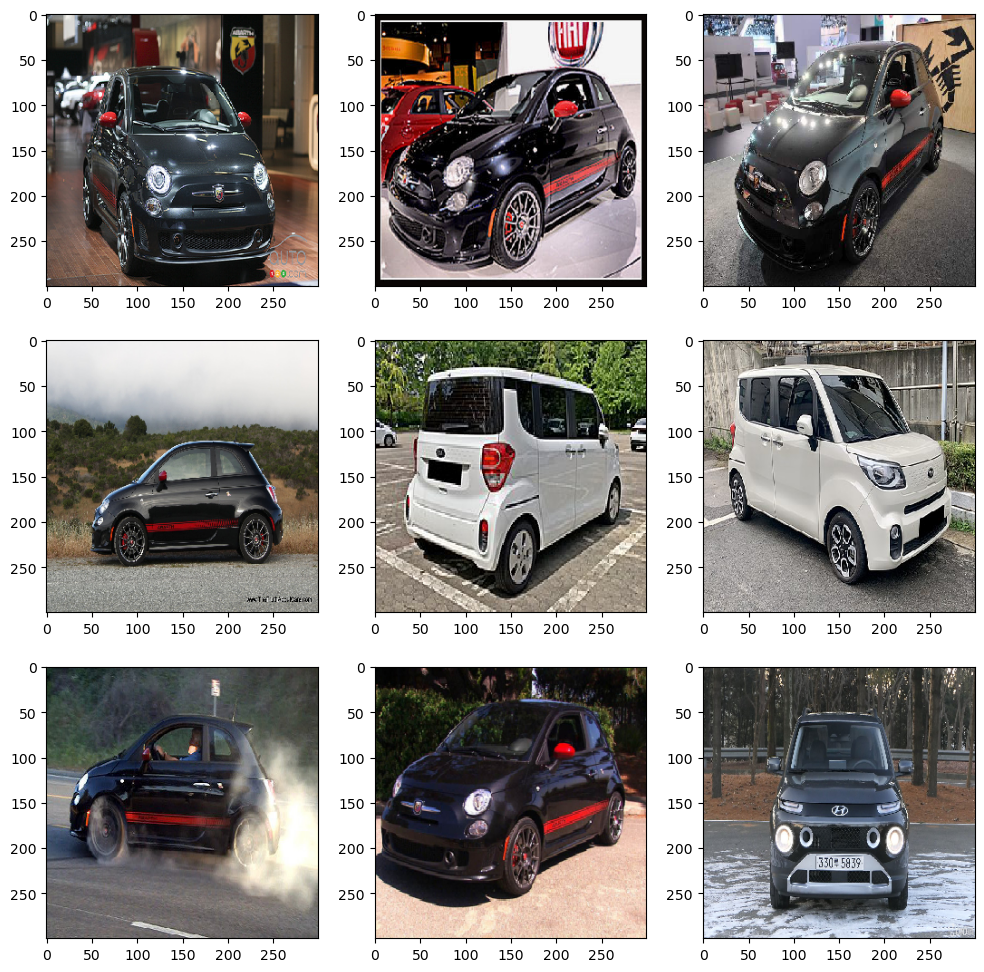

In [11]:
plot_type('compact')

In [12]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)
            
train_dict = dict()
walk_data(train_dict, folder_path)

def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k] = v
    return new_dict

train_dict = fix_keys(train_dict)

print(train_dict)

{'car_semi_total\\bus': 613, 'car_semi_total\\compact': 1049, 'car_semi_total\\sedan': 3929, 'car_semi_total\\suv': 3202, 'car_semi_total\\truck': 722, 'car_semi_total\\Van': 873}


In [13]:
label_train_dict = {'Car Types':train_dict.keys(), 'Count':train_dict.values}
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()
    
plot_dist(train_dict, "Training data")

In [17]:
datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2, 
    zoom_range=.2,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_set = datagen.flow_from_directory(folder_path,
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

val_set = datagen.flow_from_directory(folder_path,
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False)

Found 8314 images belonging to 6 classes.
Found 2074 images belonging to 6 classes.


In [14]:
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",
                                                input_shape=(pic_size, pic_size, 3), pooling='max') 
x = base_model.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),
                          activity_regularizer=tf.keras.regularizers.l1(0.006),
                          bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='relu')(x)
x = tf.keras.layers.Dropout(rate=.45, seed=123)(x)        
output = tf.keras.layers.Dense(6, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.compile(tf.keras.optimizers.Adamax(learning_rate=.001), loss='categorical_crossentropy', 
              metrics=['accuracy']) 

In [15]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [16]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [17]:
# 모델 최적화 구간설정 및 최종 결과파라미터 저장
modelpath = './cartype_model_B4_data5vs5.h5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss',
                              verbose = 1, save_best_only = True)
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5)


history = model.fit(train_set, 
                    validation_data = val_set,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose=1,
                    callbacks = [checkpointer, early_stopping_callback])


Epoch 1/20
  2/520 [..............................] - ETA: 3:59 - loss: 10.6867 - accuracy: 0.1562   

C:\Users\ygl\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



520/520 [==============================] - 290s 528ms/step - loss: 6.5502 - accuracy: 0.7284 - val_loss: 4.3622 - val_accuracy: 0.8525

Epoch 00001: val_loss improved from inf to 4.36221, saving model to .\cartype_model_B4_data5vs5.h5


C:\Users\ygl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/20
520/520 [==============================] - 274s 527ms/step - loss: 2.9179 - accuracy: 0.8999 - val_loss: 2.0258 - val_accuracy: 0.8828

Epoch 00002: val_loss improved from 4.36221 to 2.02579, saving model to .\cartype_model_B4_data5vs5.h5
Epoch 3/20
520/520 [==============================] - 276s 529ms/step - loss: 1.3318 - accuracy: 0.9366 - val_loss: 1.0395 - val_accuracy: 0.8978

Epoch 00003: val_loss improved from 2.02579 to 1.03946, saving model to .\cartype_model_B4_data5vs5.h5
Epoch 4/20
520/520 [==============================] - 275s 527ms/step - loss: 0.7034 - accuracy: 0.9537 - val_loss: 0.7616 - val_accuracy: 0.8872

Epoch 00004: val_loss improved from 1.03946 to 0.76163, saving model to .\cartype_model_B4_data5vs5.h5
Epoch 5/20
520/520 [==============================] - 273s 524ms/step - loss: 0.4687 - accuracy: 0.9625 - val_loss: 0.5135 - val_accuracy: 0.9277

Epoch 00005: val_loss improved from 0.76163 to 0.51355, saving model to .\cartype_model_B4_data5vs5.h5


ResourceExhaustedError:  OOM when allocating tensor with shape[16,1792,10,10] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/top_activation/Sigmoid (defined at \AppData\Local\Temp\ipykernel_9784\3318398977.py:8) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_31877]

Function call stack:
train_function


In [14]:
from tensorflow.keras.models import Model, load_model, Sequential

In [15]:
model = load_model('./cartype_model_B4_data5vs5.h5')

NameError: name 'history' is not defined

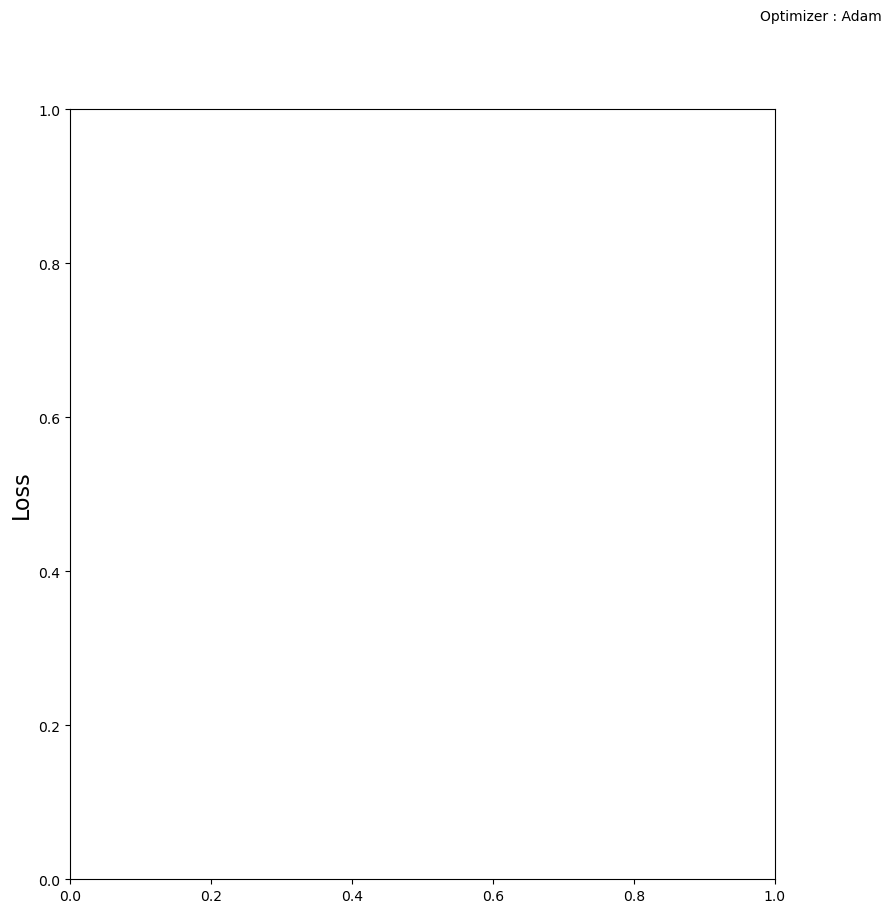

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [18]:
results = model.evaluate(val_set)
preds   = model.predict(val_set)
print('현재 모델은 {}%와 같은 정확도를 달성했다.'.format(round(results[1]*100,2)))

 10/130 [=>............................] - ETA: 3:20 - loss: 0.3819 - accuracy: 0.9438

C:\Users\LG\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



130/130 [==============================] - 261s 2s/step
현재 모델은 93.2%와 같은 정확도를 달성했다.


In [19]:
predictions = model.predict(val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

130/130 [==============================] - 274s 2s/step


In [23]:
print(class_names)
print(y_pred)
print(y_test)

dict_keys(['Van', 'bus', 'compact', 'sedan', 'suv', 'truck'])
[0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 3, 2, 3, 2, 2, 3, 3, 4, 2, 3, 2, 2, 2, 2, 2

In [25]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

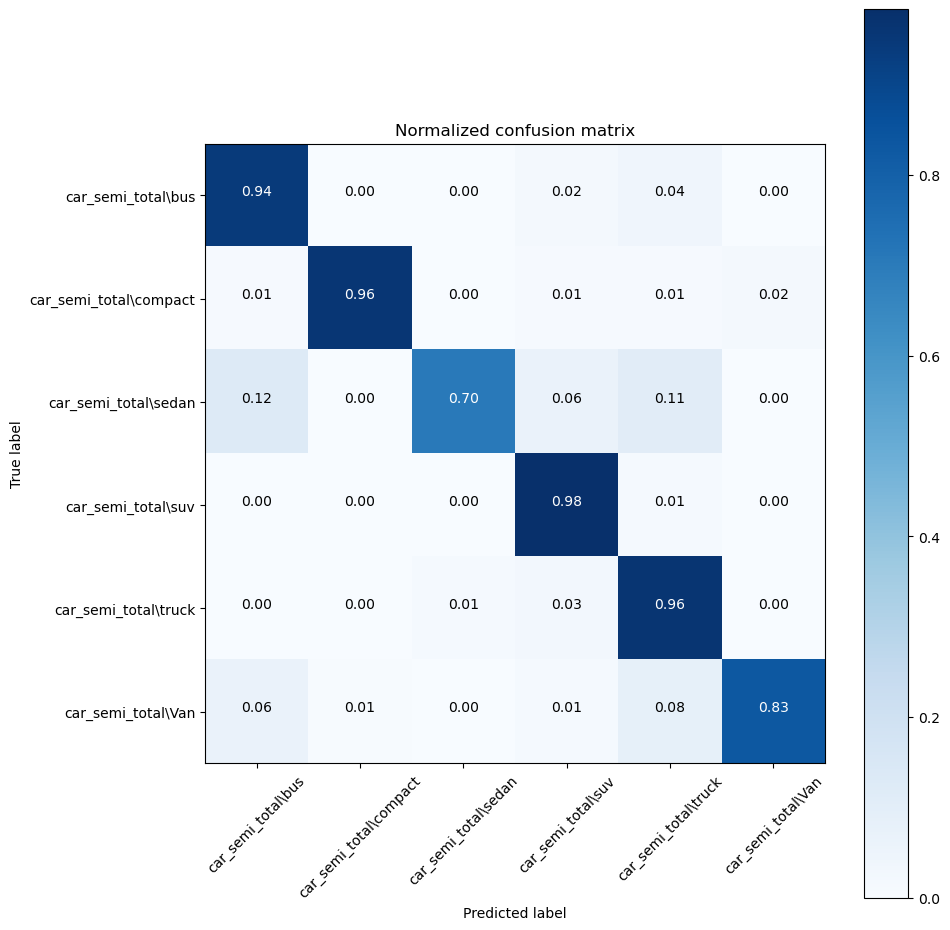

In [26]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=train_dict.keys(), title='Normalized confusion matrix')
plt.show()